<a href="https://colab.research.google.com/github/romqn1999/Predict-price-after-pattern/blob/model-classification/Classify_price_after_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
from google.colab import files
uploaded = files.upload()

Saving ZM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to ZM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns (1).csv
Saving Z_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to Z_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns (1).csv
Saving Y_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to Y_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns (1).csv
Saving XPEV_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to XPEV_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns (1).csv
Saving XOM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to XOM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns (1).csv
Saving X_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to X_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns (1).csv
Saving WMT_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv to WMT_2000-01-01 00_00_00_2021-05-30_30_double_to

## Import packages

In [3]:
import math
import matplotlib.pyplot as plt
import keras
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras import optimizers
from keras.optimizers import Adagrad, Adadelta, RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

## Get data at pattern for training & testing

In [4]:
import io
import pandas as pd

price_patterns_df = pd.DataFrame()
for filename in uploaded.keys():
    print(filename)
    if 'double_top_data_patterns.csv' not in filename:
    # if 'data_patterns.csv' not in filename:
        print('Skipping file', filename)
        continue
    df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')),
                     header=None)
    price_patterns_df = price_patterns_df.append(df)

price_patterns_df = price_patterns_df.sample(frac=1).reset_index(drop=True)
price_patterns_df

ZM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Z_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
Y_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
XPEV_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
XOM_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
X_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
WMT_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
WFC_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
W_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
VZ_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
VXRT_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
VICI_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
VIAC_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
V_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
TSLA_2000-01-01 00_00_00_2021-05-30_30_double_top_data_patterns.csv
T_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,11.210000,11.310000,11.350000,11.410000,11.450000,11.450000,11.400000,11.320000,11.200000,11.270000,11.380000,11.450000,11.290000,11.370000,11.240000,11.180000,11.120000,11.200000,11.230000,11.180000,11.020000,11.010000,11.030000,11.100000,11.180000,11.260000,11.080000,11.040000,10.950000,10.790000,10.800000
1,43.849998,43.900002,44.750000,44.349998,44.660000,44.849998,45.770000,45.509998,45.990002,45.490002,45.090000,45.099998,45.549999,45.560001,45.439999,44.990002,45.000000,45.060001,45.060001,44.630001,45.160000,44.889999,44.590000,44.770000,45.560001,44.900002,44.669998,44.880001,44.689999,44.310001,44.570000
2,32.180000,31.780001,32.340000,32.740002,32.619999,32.150002,32.029999,32.500000,32.650002,32.520000,32.150002,32.480000,32.549999,32.380001,32.980000,32.799999,32.540001,32.380001,32.080002,32.119999,32.750000,33.419998,32.619999,32.200001,32.560001,32.419998,32.040001,32.330002,32.200001,31.530001,31.580000
3,14.150000,13.010000,12.420000,12.310000,11.900000,10.720000,10.610000,12.580000,12.330000,12.630000,12.660000,12.250000,12.000000,12.030000,11.970000,12.070000,15.280000,14.750000,14.310000,14.600000,15.000000,15.000000,14.980000,14.970000,14.990000,14.990000,15.060000,15.000000,14.450000,14.000000,13.250000
4,19.000000,19.250000,19.250000,19.049999,19.299999,19.150000,18.799999,18.850000,18.600000,18.549999,18.799999,18.549999,18.500000,18.500000,18.600000,18.650000,18.850000,18.750000,18.750000,18.650000,19.299999,19.450001,19.250000,18.950001,19.200001,19.049999,19.100000,19.000000,18.600000,18.400000,18.700001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9974,41.869999,43.299999,43.310001,43.150002,43.820000,44.369999,44.220001,45.820000,45.439999,45.380001,45.720001,45.040001,46.130001,44.660000,44.869999,44.680000,44.099998,43.630001,43.619999,43.750000,43.980000,44.410000,44.680000,45.240002,45.230000,45.070000,44.389999,44.580002,44.459999,43.529999,43.570000
9975,39.090000,39.599998,39.430000,39.650002,40.709999,40.009998,39.939999,39.320000,38.650002,38.250000,39.290001,38.820000,38.939999,38.529999,39.779999,40.139999,39.950001,39.990002,39.740002,39.430000,39.330002,39.279999,39.139999,39.349998,42.669998,43.419998,42.279999,42.709999,43.080002,42.209999,41.900002
9976,42.389999,41.919998,42.099998,41.169998,41.590000,41.630001,41.680000,41.790001,41.450001,41.230000,42.400002,42.369999,42.169998,41.990002,41.810001,41.730000,42.110001,41.970001,41.849998,42.130001,42.049999,42.459999,43.299999,43.200001,42.950001,42.500000,42.400002,41.520000,41.389999,40.689999,40.099998
9977,118.209999,118.519997,116.000000,117.459999,116.970001,117.620003,118.110001,118.250000,116.849998,117.529999,116.820000,116.050003,115.589996,115.800003,115.269997,115.449997,115.459999,115.669998,116.239998,116.139999,118.610001,116.949997,117.230003,119.970001,119.809998,117.209999,120.330002,119.180000,117.250000,115.989998,117.320000


In [5]:
#@title Check if data is nearly formed a line
#@markdown ### Delta price distance from data point to trend line
trend_delta = 0.05 #@param {type:"number"}

def is_trend(x_data, y_data):
    assert len(x_data) == len(y_data)
    if len(x_data) < 2:
        return False
    # print(x_data)
    # print(y_data)
    # Find the line from the first to the last point
    # y = a * x + b
    x1, y1 = x_data[0], y_data[0]
    x2, y2 = x_data[-1], y_data[-1]
    a = (y1 - y2) / (x1 - x2)  # slope
    b = y1 - a * x1  # intercept
    b_is_trend = True
    for i in range(len(x_data)):
        y_val = a * x_data[i] + b
        err = abs(y_val - y_data[i])
        if (err > trend_delta * y_val):
            b_is_trend = False
            break
    return b_is_trend
    # p, res, _, _, _ = np.polyfit(x_data, y_data, 1, full=True)
    # err = res[0] if res.size > 0 else 0
    # if err <= len(x_data) * trend_delta:
    #     return True
    # return False

In [6]:
#@markdown ### Delta price distance between 2 tops/bottoms
y_delta =  0.5#@param {type:"number"}
min_height = 0.5 #@param {type:"number"}

In [7]:
def find_double_top(x_data, y_data, key_points=None):
    assert len(x_data) == len(y_data)
    if key_points is None:        
        #           ___ detection of local minimums and maximums ___
        min_max = np.diff(np.sign(np.diff(y_data))).nonzero()[0] + 1          # local min & max
        l_min = (np.diff(np.sign(np.diff(y_data))) > 0).nonzero()[0] + 1      # local min
        l_max = (np.diff(np.sign(np.diff(y_data))) < 0).nonzero()[0] + 1      # local max
        # +1 due to the fact that diff reduces the original index number
        key_points = min_max

    suspected_double_tops = list()
    n = len(x_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 3):
        for j in range(i + 2, len(key_points) - 1):
            l = key_points[i]
            r = key_points[j]
            # if l == 301 and r == 307:
            #     print(y_data[l], y_data[r], max(y_data[key_points[i + 1: j]]))
            if (abs(y_data[l] - y_data[r]) <= y_delta) \
               and r - l > 1 \
               and min(y_data[l], y_data[r]) >= max(y_data[key_points[i + 1: j]]):
                k_bottom = np.argmin(y_data[l + 1: r]) + l + 1
                if min(y_data[l], y_data[r]) < y_data[k_bottom] + min_height:
                    continue
                (ilows,) = np.where(y_data[:l] <= y_data[k_bottom])
                istart = None
                if ilows.size > 0:
                    istart = ilows[-1]
                (ilows,) = np.where(y_data[r:] <= y_data[k_bottom])
                iend = None
                if ilows.size > 0:
                    iend = ilows[0] + r
                # print(istart, l, k_bottom, r, iend)
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart:l + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_tops.append((istart, l, k_bottom, r, iend))
    return suspected_double_tops

In [8]:
def find_double_bottom(x_data, y_data, key_points=None):
    assert len(x_data) == len(y_data)
    if key_points is None:        
        #           ___ detection of local minimums and maximums ___
        min_max = np.diff(np.sign(np.diff(y_data))).nonzero()[0] + 1          # local min & max
        l_min = (np.diff(np.sign(np.diff(y_data))) > 0).nonzero()[0] + 1      # local min
        l_max = (np.diff(np.sign(np.diff(y_data))) < 0).nonzero()[0] + 1      # local max
        # +1 due to the fact that diff reduces the original index number
        key_points = min_max

    suspected_double_bottoms = list()
    n = len(x_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 3):
        for j in range(i + 2, len(key_points) - 1):
            l = key_points[i]
            r = key_points[j]
            if (abs(y_data[l] - y_data[r]) <= y_delta) \
               and r - l > 1 \
               and max(y_data[l], y_data[r]) <= min(y_data[key_points[i + 1: j]]):
                k_top = np.argmax(y_data[l + 1: r]) + l + 1
                if max(y_data[l], y_data[r]) + min_height > y_data[k_top]:
                    continue
                (ihights,) = np.where(y_data[:l] >= y_data[k_top])
                istart = None
                if ihights.size > 0:
                    istart = ihights[-1]
                (ihights,) = np.where(y_data[r:] >= y_data[k_top])
                iend = None
                if ihights.size > 0:
                    iend = ihights[0] + r
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart:l + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_bottoms.append((istart, l, k_top, r, iend))
    return suspected_double_bottoms

In [9]:
for i, row in price_patterns_df.iterrows():
    double_tops = find_double_top(range(len(row)), row.to_numpy())
    double_bots = find_double_bottom(range(len(row)), row.to_numpy())
    print(i, double_tops, double_bots)

Streaming output truncated to the last 5000 lines.
4979 [(18, 22, 24, 26, 29)] []
4980 [(16, 19, 21, 24, 25)] []
4981 [(23, 26, 27, 28, 29)] [(22, 23, 26, 27, 28)]
4982 [(16, 18, 22, 24, 29)] []
4983 [(11, 12, 14, 16, 17)] [(9, 11, 12, 14, 16)]
4984 [(20, 23, 25, 26, 27), (20, 26, 27, 28, 29)] []
4985 [(1, 3, 4, 5, 6), (15, 16, 18, 21, 22), (15, 17, 18, 21, 22), (24, 25, 26, 28, 29)] [(23, 24, 25, 26, 28), (23, 24, 25, 27, 28)]
4986 [(21, 23, 24, 25, 29)] []
4987 [] []
4988 [(4, 7, 9, 11, 13), (4, 7, 13, 20, 29), (4, 11, 13, 18, 29), (4, 11, 13, 20, 29), (15, 20, 22, 27, 29)] [(7, 9, 11, 13, 20)]
4989 [] []
4990 [(6, 9, 10, 16, 24)] []
4991 [(7, 14, 17, 20, 27), (7, 14, 17, 23, 27)] []
4992 [] []
4993 [(11, 16, 21, 26, 29), (11, 16, 21, 28, 29), (11, 18, 21, 26, 29), (11, 19, 21, 26, 29)] [(2, 3, 4, 9, 12), (2, 3, 4, 11, 12)]
4994 [(21, 22, 24, 27, 29)] [(18, 19, 20, 21, 22)]
4995 [] [(12, 15, 16, 18, 22)]
4996 [] []
4997 [(19, 22, 24, 25, 29)] []
4998 [(17, 20, 21, 24, 29)] []
4999 [(

In [10]:
#@title Separate into input and output columns: Get data: X and y

X_df = price_patterns_df[price_patterns_df.columns[:-1]]
y_df = price_patterns_df[price_patterns_df.columns[-1:]]
print(X_df)
print(y_df)

X_data = X_df.values
y_data = y_df.values
print(X_data)
print(y_data)

              0           1           2   ...          27          28          29
0      11.210000   11.310000   11.350000  ...   11.040000   10.950000   10.790000
1      43.849998   43.900002   44.750000  ...   44.880001   44.689999   44.310001
2      32.180000   31.780001   32.340000  ...   32.330002   32.200001   31.530001
3      14.150000   13.010000   12.420000  ...   15.000000   14.450000   14.000000
4      19.000000   19.250000   19.250000  ...   19.000000   18.600000   18.400000
...          ...         ...         ...  ...         ...         ...         ...
9974   41.869999   43.299999   43.310001  ...   44.580002   44.459999   43.529999
9975   39.090000   39.599998   39.430000  ...   42.709999   43.080002   42.209999
9976   42.389999   41.919998   42.099998  ...   41.520000   41.389999   40.689999
9977  118.209999  118.519997  116.000000  ...  119.180000  117.250000  115.989998
9978   22.879999   21.620001   22.230000  ...   21.570000   21.799999   20.860001

[9979 rows x 30

In [11]:
def get_direction(pre, cur, min_change=1):
    if abs(pre - cur) < min_change:
        return 0
    else:
        if pre < cur:
            return 1
        else:
            return -1

def y_preice_to_y_label(X, y, min_change=0):
    assert len(X) == len(y)
    n = len(y)
    y_label = np.array([get_direction(X[i][-1], y[i], min_change) for i in range(n)])
    # Convert from {-1; 0; 1} to label {0; 1; 2}
    y_label = y_label + 1
    return y_label

In [22]:
#@title Preprocess & split data for train model
# Train, test split
train_ratio = 0.8 #@param {type:"number"}
if train_ratio < 0 or  train_ratio > 1:
    train_ratio = 0.8
n_data = len(X_data)
n_train = int(train_ratio * n_data)
n_test = n_data - n_train
# Feature Scaling
scale_method = "MinMax" #@param ["None", "MinMax"]
min_price_change = 0 #@param {type:"number"}

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=train_ratio, random_state=7)
# X_train, y_train = X_data[: n_train], y_data[: n_train]
y_train_label = y_preice_to_y_label(X_train, y_train, min_price_change)
y_train_categorical = to_categorical(y_train_label, num_classes=3)
# X_test, y_test = X_data[n_train:], y_data[n_train:]
y_test_label = y_preice_to_y_label(X_test, y_test, min_price_change)
y_test_categorical = to_categorical(y_test_label, num_classes=3)
if scale_method == 'MinMax':
    sc_train = MinMaxScaler(feature_range = (0, 1))
    X_train_scaled = sc_train.fit_transform(X_train.T).T
    y_train_scaled = sc_train.transform(y_train.T).T
    y_train_scaled_label = y_preice_to_y_label(X_train_scaled, y_train_scaled, min_price_change)
    y_train_scaled_categorical = to_categorical(y_train_scaled_label, num_classes=3)
    sc_test = MinMaxScaler(feature_range = (0, 1))
    X_test_scaled = sc_test.fit_transform(X_test.T).T
    y_test_scaled = sc_test.transform(y_test.T).T
    y_test_scaled_label = y_preice_to_y_label(X_test_scaled, y_test_scaled, min_price_change)
    y_test_scaled_categorical = to_categorical(y_test_scaled_label, num_classes=3)
    # X_train, y_train = X_train_scaled, y_train_scaled
    # X_test, y_test = X_test_scaled, y_test_scaled
print(X_train.shape, y_train.shape)
print(X_train_scaled.shape, y_train_scaled.shape)
print(y_train_categorical.shape)
print(y_train_scaled_categorical.shape)
print(X_test.shape, y_test.shape)
print(X_test_scaled.shape, y_test_scaled.shape)
print(y_test_categorical.shape)
print(y_test_scaled_categorical.shape)

# print(X_train)
# print(y_train)

(7983, 30) (7983, 1)
(7983, 30) (7983, 1)
(7983, 3)
(7983, 3)
(1996, 30) (1996, 1)
(1996, 30) (1996, 1)
(1996, 3)
(1996, 3)


## LSTM model

### Build model

In [23]:
#@title Build & fit model
lstm_units = 50 #@param {type:"integer"}
dropout_prob = 0.5 #@param {type:"number"}
epochs = 10000 #@param {type:"integer"}
batch_size = 32768 #@param {type:"integer"}



### Train model

Epoch 1/10000
1/1 [==============================] - 15s 15s/step - loss: 1.1060 - accuracy: 0.2014 - val_loss: 1.0881 - val_accuracy: 0.5015

Epoch 00001: val_accuracy improved from -inf to 0.50150, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 2/10000
1/1 [==============================] - 0s 380ms/step - loss: 1.0890 - accuracy: 0.4940 - val_loss: 1.0734 - val_accuracy: 0.4980

Epoch 00002: val_accuracy did not improve from 0.50150
Epoch 3/10000
1/1 [==============================] - 0s 309ms/step - loss: 1.0738 - accuracy: 0.5016 - val_loss: 1.0555 - val_accuracy: 0.4980

Epoch 00003: val_accuracy did not improve from 0.50150
Epoch 4/10000
1/1 [==============================] - 0s 283ms/step - loss: 1.0564 - accuracy: 0.5022 - val_loss: 1.0309 - val_accuracy: 0.4980

Epoch 00004: val_accuracy did not improve from 0.50150
Epoch 5/10000
1/1 [==============================] - 0s 267ms/step - loss: 1.0332 - accuracy: 0.5034 - val_loss: 0.9985 - val_accuracy: 0.4980

Epoch 00005: val_accuracy did not improve from 0.50150
Epoch 6/10000
1/1 [==============================] - 0s 270ms/step - loss: 1.0019 - accuracy: 0.5066 - val_loss: 0.9570 - val_accuracy: 0.4980

Epoch 00006: val_accuracy did not improve from 0.50150
Epoch

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 13/10000
1/1 [==============================] - 0s 263ms/step - loss: 0.7452 - accuracy: 0.4987 - val_loss: 0.7150 - val_accuracy: 0.5020

Epoch 00013: val_accuracy did not improve from 0.50200
Epoch 14/10000
1/1 [==============================] - 0s 266ms/step - loss: 0.7394 - accuracy: 0.4937 - val_loss: 0.7157 - val_accuracy: 0.5020

Epoch 00014: val_accuracy did not improve from 0.50200
Epoch 15/10000
1/1 [==============================] - 0s 269ms/step - loss: 0.7316 - accuracy: 0.5021 - val_loss: 0.7128 - val_accuracy: 0.5020

Epoch 00015: val_accuracy did not improve from 0.50200
Epoch 16/10000
1/1 [==============================] - 0s 268ms/step - loss: 0.7295 - accuracy: 0.4933 - val_loss: 0.7058 - val_accuracy: 0.5020

Epoch 00016: val_accuracy did not improve from 0.50200
Epoch 17/10000
1/1 [==============================] - 0s 266ms/step - loss: 0.7227 - accuracy: 0.5027 - val_loss: 0.6996 - val_accuracy: 0.5020

Epoch 00017: val_accuracy did not improve from 0.50200


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 66/10000
1/1 [==============================] - 0s 356ms/step - loss: 0.6954 - accuracy: 0.4999 - val_loss: 0.6934 - val_accuracy: 0.4985

Epoch 00066: val_accuracy did not improve from 0.50501
Epoch 67/10000
1/1 [==============================] - 0s 312ms/step - loss: 0.6967 - accuracy: 0.4964 - val_loss: 0.6934 - val_accuracy: 0.5020

Epoch 00067: val_accuracy did not improve from 0.50501
Epoch 68/10000
1/1 [==============================] - 0s 278ms/step - loss: 0.6952 - accuracy: 0.5051 - val_loss: 0.6934 - val_accuracy: 0.5020

Epoch 00068: val_accuracy did not improve from 0.50501
Epoch 69/10000
1/1 [==============================] - 0s 277ms/step - loss: 0.6964 - accuracy: 0.4909 - val_loss: 0.6934 - val_accuracy: 0.5020

Epoch 00069: val_accuracy did not improve from 0.50501
Epoch 70/10000
1/1 [==============================] - 0s 269ms/step - loss: 0.6957 - accuracy: 0.4998 - val_loss: 0.6934 - val_accuracy: 0.5020

Epoch 00070: val_accuracy did not improve from 0.50501


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 108/10000
1/1 [==============================] - 0s 263ms/step - loss: 0.6942 - accuracy: 0.5060 - val_loss: 0.6933 - val_accuracy: 0.4980

Epoch 00108: val_accuracy did not improve from 0.50651
Epoch 109/10000
1/1 [==============================] - 0s 271ms/step - loss: 0.6946 - accuracy: 0.5002 - val_loss: 0.6933 - val_accuracy: 0.4980

Epoch 00109: val_accuracy did not improve from 0.50651
Epoch 110/10000
1/1 [==============================] - 0s 271ms/step - loss: 0.6945 - accuracy: 0.5029 - val_loss: 0.6933 - val_accuracy: 0.4980

Epoch 00110: val_accuracy did not improve from 0.50651
Epoch 111/10000
1/1 [==============================] - 0s 270ms/step - loss: 0.6947 - accuracy: 0.5014 - val_loss: 0.6933 - val_accuracy: 0.4980

Epoch 00111: val_accuracy did not improve from 0.50651
Epoch 112/10000
1/1 [==============================] - 0s 270ms/step - loss: 0.6941 - accuracy: 0.5072 - val_loss: 0.6933 - val_accuracy: 0.4980

Epoch 00112: val_accuracy did not improve from 0.5

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 663/10000
1/1 [==============================] - 0s 348ms/step - loss: 0.6930 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4995

Epoch 00663: val_accuracy did not improve from 0.50752
Epoch 664/10000
1/1 [==============================] - 0s 294ms/step - loss: 0.6935 - accuracy: 0.5042 - val_loss: 0.6932 - val_accuracy: 0.5040

Epoch 00664: val_accuracy did not improve from 0.50752
Epoch 665/10000
1/1 [==============================] - 0s 310ms/step - loss: 0.6928 - accuracy: 0.5147 - val_loss: 0.6931 - val_accuracy: 0.5070

Epoch 00665: val_accuracy did not improve from 0.50752
Epoch 666/10000
1/1 [==============================] - 0s 274ms/step - loss: 0.6930 - accuracy: 0.5091 - val_loss: 0.6931 - val_accuracy: 0.5045

Epoch 00666: val_accuracy did not improve from 0.50752
Epoch 667/10000
1/1 [==============================] - 0s 266ms/step - loss: 0.6929 - accuracy: 0.5096 - val_loss: 0.6931 - val_accuracy: 0.5040

Epoch 00667: val_accuracy did not improve from 0.5

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 1745/10000
1/1 [==============================] - 0s 356ms/step - loss: 0.6885 - accuracy: 0.5292 - val_loss: 0.6961 - val_accuracy: 0.4975

Epoch 01745: val_accuracy did not improve from 0.50802
Epoch 1746/10000
1/1 [==============================] - 0s 309ms/step - loss: 0.6892 - accuracy: 0.5232 - val_loss: 0.6963 - val_accuracy: 0.5005

Epoch 01746: val_accuracy did not improve from 0.50802
Epoch 1747/10000
1/1 [==============================] - 0s 281ms/step - loss: 0.6889 - accuracy: 0.5280 - val_loss: 0.6964 - val_accuracy: 0.4995

Epoch 01747: val_accuracy did not improve from 0.50802
Epoch 1748/10000
1/1 [==============================] - 0s 271ms/step - loss: 0.6898 - accuracy: 0.5209 - val_loss: 0.6964 - val_accuracy: 0.5010

Epoch 01748: val_accuracy did not improve from 0.50802
Epoch 1749/10000
1/1 [==============================] - 0s 280ms/step - loss: 0.6887 - accuracy: 0.5239 - val_loss: 0.6965 - val_accuracy: 0.5080

Epoch 01749: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 1795/10000
1/1 [==============================] - 0s 355ms/step - loss: 0.6881 - accuracy: 0.5281 - val_loss: 0.6955 - val_accuracy: 0.5065

Epoch 01795: val_accuracy did not improve from 0.50902
Epoch 1796/10000
1/1 [==============================] - 0s 308ms/step - loss: 0.6882 - accuracy: 0.5230 - val_loss: 0.6952 - val_accuracy: 0.5035

Epoch 01796: val_accuracy did not improve from 0.50902
Epoch 1797/10000
1/1 [==============================] - 0s 278ms/step - loss: 0.6879 - accuracy: 0.5303 - val_loss: 0.6953 - val_accuracy: 0.5040

Epoch 01797: val_accuracy did not improve from 0.50902
Epoch 1798/10000
1/1 [==============================] - 0s 277ms/step - loss: 0.6889 - accuracy: 0.5197 - val_loss: 0.6957 - val_accuracy: 0.5005

Epoch 01798: val_accuracy did not improve from 0.50902
Epoch 1799/10000
1/1 [==============================] - 0s 275ms/step - loss: 0.6881 - accuracy: 0.5286 - val_loss: 0.6962 - val_accuracy: 0.4995

Epoch 01799: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 1826/10000
1/1 [==============================] - 0s 276ms/step - loss: 0.6882 - accuracy: 0.5287 - val_loss: 0.6965 - val_accuracy: 0.5100

Epoch 01826: val_accuracy did not improve from 0.51002
Epoch 1827/10000
1/1 [==============================] - 0s 278ms/step - loss: 0.6882 - accuracy: 0.5335 - val_loss: 0.6971 - val_accuracy: 0.5000

Epoch 01827: val_accuracy did not improve from 0.51002
Epoch 1828/10000
1/1 [==============================] - 0s 269ms/step - loss: 0.6881 - accuracy: 0.5224 - val_loss: 0.6971 - val_accuracy: 0.4965

Epoch 01828: val_accuracy did not improve from 0.51002
Epoch 1829/10000
1/1 [==============================] - 0s 269ms/step - loss: 0.6880 - accuracy: 0.5269 - val_loss: 0.6965 - val_accuracy: 0.5035

Epoch 01829: val_accuracy did not improve from 0.51002
Epoch 1830/10000
1/1 [==============================] - 0s 275ms/step - loss: 0.6884 - accuracy: 0.5300 - val_loss: 0.6962 - val_accuracy: 0.4925

Epoch 01830: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 1886/10000
1/1 [==============================] - 0s 359ms/step - loss: 0.6885 - accuracy: 0.5280 - val_loss: 0.6963 - val_accuracy: 0.5005

Epoch 01886: val_accuracy did not improve from 0.51403
Epoch 1887/10000
1/1 [==============================] - 0s 301ms/step - loss: 0.6869 - accuracy: 0.5368 - val_loss: 0.6968 - val_accuracy: 0.5075

Epoch 01887: val_accuracy did not improve from 0.51403
Epoch 1888/10000
1/1 [==============================] - 0s 271ms/step - loss: 0.6878 - accuracy: 0.5219 - val_loss: 0.6974 - val_accuracy: 0.4980

Epoch 01888: val_accuracy did not improve from 0.51403
Epoch 1889/10000
1/1 [==============================] - 0s 306ms/step - loss: 0.6873 - accuracy: 0.5338 - val_loss: 0.6974 - val_accuracy: 0.5000

Epoch 01889: val_accuracy did not improve from 0.51403
Epoch 1890/10000
1/1 [==============================] - 0s 307ms/step - loss: 0.6875 - accuracy: 0.5252 - val_loss: 0.6974 - val_accuracy: 0.4930

Epoch 01890: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 1970/10000
1/1 [==============================] - 0s 349ms/step - loss: 0.6880 - accuracy: 0.5229 - val_loss: 0.6977 - val_accuracy: 0.5030

Epoch 01970: val_accuracy did not improve from 0.51453
Epoch 1971/10000
1/1 [==============================] - 0s 327ms/step - loss: 0.6864 - accuracy: 0.5323 - val_loss: 0.6975 - val_accuracy: 0.5005

Epoch 01971: val_accuracy did not improve from 0.51453
Epoch 1972/10000
1/1 [==============================] - 0s 283ms/step - loss: 0.6877 - accuracy: 0.5341 - val_loss: 0.6972 - val_accuracy: 0.5020

Epoch 01972: val_accuracy did not improve from 0.51453
Epoch 1973/10000
1/1 [==============================] - 0s 291ms/step - loss: 0.6882 - accuracy: 0.5259 - val_loss: 0.6974 - val_accuracy: 0.5030

Epoch 01973: val_accuracy did not improve from 0.51453
Epoch 1974/10000
1/1 [==============================] - 0s 278ms/step - loss: 0.6875 - accuracy: 0.5270 - val_loss: 0.6994 - val_accuracy: 0.5030

Epoch 01974: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 2102/10000
1/1 [==============================] - 0s 361ms/step - loss: 0.6866 - accuracy: 0.5319 - val_loss: 0.6979 - val_accuracy: 0.5050

Epoch 02102: val_accuracy did not improve from 0.51603
Epoch 2103/10000
1/1 [==============================] - 0s 302ms/step - loss: 0.6869 - accuracy: 0.5295 - val_loss: 0.6994 - val_accuracy: 0.4985

Epoch 02103: val_accuracy did not improve from 0.51603
Epoch 2104/10000
1/1 [==============================] - 0s 288ms/step - loss: 0.6872 - accuracy: 0.5279 - val_loss: 0.6992 - val_accuracy: 0.4985

Epoch 02104: val_accuracy did not improve from 0.51603
Epoch 2105/10000
1/1 [==============================] - 0s 272ms/step - loss: 0.6868 - accuracy: 0.5254 - val_loss: 0.6989 - val_accuracy: 0.4965

Epoch 02105: val_accuracy did not improve from 0.51603
Epoch 2106/10000
1/1 [==============================] - 0s 277ms/step - loss: 0.6865 - accuracy: 0.5301 - val_loss: 0.6990 - val_accuracy: 0.5010

Epoch 02106: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 2341/10000
1/1 [==============================] - 0s 349ms/step - loss: 0.6857 - accuracy: 0.5321 - val_loss: 0.7032 - val_accuracy: 0.5100

Epoch 02341: val_accuracy did not improve from 0.51854
Epoch 2342/10000
1/1 [==============================] - 0s 291ms/step - loss: 0.6842 - accuracy: 0.5385 - val_loss: 0.7037 - val_accuracy: 0.4955

Epoch 02342: val_accuracy did not improve from 0.51854
Epoch 2343/10000
1/1 [==============================] - 0s 284ms/step - loss: 0.6834 - accuracy: 0.5411 - val_loss: 0.7028 - val_accuracy: 0.5030

Epoch 02343: val_accuracy did not improve from 0.51854
Epoch 2344/10000
1/1 [==============================] - 0s 281ms/step - loss: 0.6846 - accuracy: 0.5351 - val_loss: 0.7052 - val_accuracy: 0.5060

Epoch 02344: val_accuracy did not improve from 0.51854
Epoch 2345/10000
1/1 [==============================] - 0s 271ms/step - loss: 0.6855 - accuracy: 0.5326 - val_loss: 0.7075 - val_accuracy: 0.4950

Epoch 02345: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 3563/10000
1/1 [==============================] - 0s 362ms/step - loss: 0.6358 - accuracy: 0.5849 - val_loss: 0.7965 - val_accuracy: 0.5230

Epoch 03563: val_accuracy improved from 0.52004 to 0.52305, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 3564/10000
1/1 [==============================] - 0s 324ms/step - loss: 0.6463 - accuracy: 0.5855 - val_loss: 0.7904 - val_accuracy: 0.5170

Epoch 03564: val_accuracy did not improve from 0.52305
Epoch 3565/10000
1/1 [==============================] - 0s 291ms/step - loss: 0.6528 - accuracy: 0.5774 - val_loss: 0.7683 - val_accuracy: 0.5100

Epoch 03565: val_accuracy did not improve from 0.52305
Epoch 3566/10000
1/1 [==============================] - 0s 282ms/step - loss: 0.6484 - accuracy: 0.5851 - val_loss: 0.7609 - val_accuracy: 0.5055

Epoch 03566: val_accuracy did not improve from 0.52305
Epoch 3567/10000
1/1 [==============================] - 0s 312ms/step - loss: 0.6494 - accuracy: 0.5822 - val_loss: 0.7633 - val_accuracy: 0.4945

Epoch 03567: val_accuracy did not improve from 0.52305
Epoch 3568/10000
1/1 [==============================] - 0s 282ms/step - loss: 0.6497 - accuracy: 0.5762 - val_loss: 0.7697 - val_accuracy: 0.4930

Epoch 03568: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 3574/10000
1/1 [==============================] - 0s 355ms/step - loss: 0.6550 - accuracy: 0.5667 - val_loss: 0.7640 - val_accuracy: 0.5190

Epoch 03574: val_accuracy did not improve from 0.52455
Epoch 3575/10000
1/1 [==============================] - 0s 312ms/step - loss: 0.6502 - accuracy: 0.5820 - val_loss: 0.7628 - val_accuracy: 0.5160

Epoch 03575: val_accuracy did not improve from 0.52455
Epoch 3576/10000
1/1 [==============================] - 0s 319ms/step - loss: 0.6436 - accuracy: 0.5839 - val_loss: 0.7635 - val_accuracy: 0.5030

Epoch 03576: val_accuracy did not improve from 0.52455
Epoch 3577/10000
1/1 [==============================] - 0s 290ms/step - loss: 0.6487 - accuracy: 0.5745 - val_loss: 0.7645 - val_accuracy: 0.4985

Epoch 03577: val_accuracy did not improve from 0.52455
Epoch 3578/10000
1/1 [==============================] - 0s 275ms/step - loss: 0.6503 - accuracy: 0.5865 - val_loss: 0.7612 - val_accuracy: 0.4925

Epoch 03578: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 3880/10000
1/1 [==============================] - 0s 360ms/step - loss: 0.6252 - accuracy: 0.6038 - val_loss: 0.8081 - val_accuracy: 0.5245

Epoch 03880: val_accuracy did not improve from 0.52505
Epoch 3881/10000
1/1 [==============================] - 0s 302ms/step - loss: 0.6234 - accuracy: 0.6024 - val_loss: 0.8037 - val_accuracy: 0.5210

Epoch 03881: val_accuracy did not improve from 0.52505
Epoch 3882/10000
1/1 [==============================] - 0s 281ms/step - loss: 0.6193 - accuracy: 0.6207 - val_loss: 0.8050 - val_accuracy: 0.5100

Epoch 03882: val_accuracy did not improve from 0.52505
Epoch 3883/10000
1/1 [==============================] - 0s 276ms/step - loss: 0.6236 - accuracy: 0.6080 - val_loss: 0.8030 - val_accuracy: 0.5105

Epoch 03883: val_accuracy did not improve from 0.52505
Epoch 3884/10000
1/1 [==============================] - 0s 287ms/step - loss: 0.6201 - accuracy: 0.6110 - val_loss: 0.8033 - val_accuracy: 0.5150

Epoch 03884: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 4023/10000
1/1 [==============================] - 0s 352ms/step - loss: 0.6175 - accuracy: 0.6131 - val_loss: 0.8214 - val_accuracy: 0.5276

Epoch 04023: val_accuracy did not improve from 0.52806
Epoch 4024/10000
1/1 [==============================] - 0s 312ms/step - loss: 0.6166 - accuracy: 0.6103 - val_loss: 0.8080 - val_accuracy: 0.5095

Epoch 04024: val_accuracy did not improve from 0.52806
Epoch 4025/10000
1/1 [==============================] - 0s 284ms/step - loss: 0.6176 - accuracy: 0.6108 - val_loss: 0.8001 - val_accuracy: 0.5120

Epoch 04025: val_accuracy did not improve from 0.52806
Epoch 4026/10000
1/1 [==============================] - 0s 270ms/step - loss: 0.6186 - accuracy: 0.6127 - val_loss: 0.8010 - val_accuracy: 0.5080

Epoch 04026: val_accuracy did not improve from 0.52806
Epoch 4027/10000
1/1 [==============================] - 0s 285ms/step - loss: 0.6147 - accuracy: 0.6099 - val_loss: 0.8090 - val_accuracy: 0.5225

Epoch 04027: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 4755/10000
1/1 [==============================] - 0s 350ms/step - loss: 0.5876 - accuracy: 0.6505 - val_loss: 0.8959 - val_accuracy: 0.5195

Epoch 04755: val_accuracy did not improve from 0.53006
Epoch 4756/10000
1/1 [==============================] - 0s 297ms/step - loss: 0.5793 - accuracy: 0.6506 - val_loss: 0.8939 - val_accuracy: 0.5060

Epoch 04756: val_accuracy did not improve from 0.53006
Epoch 4757/10000
1/1 [==============================] - 0s 307ms/step - loss: 0.5794 - accuracy: 0.6599 - val_loss: 0.8926 - val_accuracy: 0.5055

Epoch 04757: val_accuracy did not improve from 0.53006
Epoch 4758/10000
1/1 [==============================] - 0s 277ms/step - loss: 0.5826 - accuracy: 0.6495 - val_loss: 0.8905 - val_accuracy: 0.5135

Epoch 04758: val_accuracy did not improve from 0.53006
Epoch 4759/10000
1/1 [==============================] - 0s 287ms/step - loss: 0.5696 - accuracy: 0.6594 - val_loss: 0.8818 - val_accuracy: 0.5195

Epoch 04759: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 4823/10000
1/1 [==============================] - 0s 358ms/step - loss: 0.5690 - accuracy: 0.6561 - val_loss: 0.8977 - val_accuracy: 0.5225

Epoch 04823: val_accuracy did not improve from 0.53056
Epoch 4824/10000
1/1 [==============================] - 0s 307ms/step - loss: 0.5731 - accuracy: 0.6605 - val_loss: 0.8930 - val_accuracy: 0.5276

Epoch 04824: val_accuracy did not improve from 0.53056
Epoch 4825/10000
1/1 [==============================] - 0s 282ms/step - loss: 0.5723 - accuracy: 0.6556 - val_loss: 0.8905 - val_accuracy: 0.5261

Epoch 04825: val_accuracy did not improve from 0.53056
Epoch 4826/10000
1/1 [==============================] - 0s 283ms/step - loss: 0.5679 - accuracy: 0.6607 - val_loss: 0.8959 - val_accuracy: 0.5225

Epoch 04826: val_accuracy did not improve from 0.53056
Epoch 4827/10000
1/1 [==============================] - 0s 280ms/step - loss: 0.5655 - accuracy: 0.6597 - val_loss: 0.9050 - val_accuracy: 0.5240

Epoch 04827: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 4933/10000
1/1 [==============================] - 0s 359ms/step - loss: 0.5624 - accuracy: 0.6694 - val_loss: 0.9038 - val_accuracy: 0.5356

Epoch 04933: val_accuracy did not improve from 0.53557
Epoch 4934/10000
1/1 [==============================] - 0s 315ms/step - loss: 0.5628 - accuracy: 0.6679 - val_loss: 0.9056 - val_accuracy: 0.5261

Epoch 04934: val_accuracy did not improve from 0.53557
Epoch 4935/10000
1/1 [==============================] - 0s 284ms/step - loss: 0.5624 - accuracy: 0.6748 - val_loss: 0.9012 - val_accuracy: 0.5180

Epoch 04935: val_accuracy did not improve from 0.53557
Epoch 4936/10000
1/1 [==============================] - 0s 278ms/step - loss: 0.5633 - accuracy: 0.6675 - val_loss: 0.8998 - val_accuracy: 0.5210

Epoch 04936: val_accuracy did not improve from 0.53557
Epoch 4937/10000
1/1 [==============================] - 0s 280ms/step - loss: 0.5600 - accuracy: 0.6677 - val_loss: 0.9036 - val_accuracy: 0.5205

Epoch 04937: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 5060/10000
1/1 [==============================] - 0s 361ms/step - loss: 0.5508 - accuracy: 0.6757 - val_loss: 0.9065 - val_accuracy: 0.5251

Epoch 05060: val_accuracy did not improve from 0.53808
Epoch 5061/10000
1/1 [==============================] - 0s 310ms/step - loss: 0.5570 - accuracy: 0.6692 - val_loss: 0.9205 - val_accuracy: 0.5286

Epoch 05061: val_accuracy did not improve from 0.53808
Epoch 5062/10000
1/1 [==============================] - 0s 286ms/step - loss: 0.5615 - accuracy: 0.6672 - val_loss: 0.9401 - val_accuracy: 0.5286

Epoch 05062: val_accuracy did not improve from 0.53808
Epoch 5063/10000
1/1 [==============================] - 0s 275ms/step - loss: 0.5542 - accuracy: 0.6742 - val_loss: 0.9383 - val_accuracy: 0.5245

Epoch 05063: val_accuracy did not improve from 0.53808
Epoch 5064/10000
1/1 [==============================] - 0s 282ms/step - loss: 0.5570 - accuracy: 0.6665 - val_loss: 0.9284 - val_accuracy: 0.5220

Epoch 05064: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 5413/10000
1/1 [==============================] - 0s 364ms/step - loss: 0.5276 - accuracy: 0.6967 - val_loss: 0.9664 - val_accuracy: 0.5371

Epoch 05413: val_accuracy did not improve from 0.54208
Epoch 5414/10000
1/1 [==============================] - 0s 303ms/step - loss: 0.5412 - accuracy: 0.6863 - val_loss: 0.9638 - val_accuracy: 0.5311

Epoch 05414: val_accuracy did not improve from 0.54208
Epoch 5415/10000
1/1 [==============================] - 0s 311ms/step - loss: 0.5352 - accuracy: 0.6906 - val_loss: 0.9561 - val_accuracy: 0.5286

Epoch 05415: val_accuracy did not improve from 0.54208
Epoch 5416/10000
1/1 [==============================] - 0s 275ms/step - loss: 0.5324 - accuracy: 0.6877 - val_loss: 0.9522 - val_accuracy: 0.5261

Epoch 05416: val_accuracy did not improve from 0.54208
Epoch 5417/10000
1/1 [==============================] - 0s 282ms/step - loss: 0.5486 - accuracy: 0.6802 - val_loss: 0.9606 - val_accuracy: 0.5240

Epoch 05417: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 5578/10000
1/1 [==============================] - 0s 360ms/step - loss: 0.5253 - accuracy: 0.6980 - val_loss: 0.9502 - val_accuracy: 0.5371

Epoch 05578: val_accuracy did not improve from 0.54259
Epoch 5579/10000
1/1 [==============================] - 0s 317ms/step - loss: 0.5314 - accuracy: 0.6913 - val_loss: 0.9505 - val_accuracy: 0.5421

Epoch 05579: val_accuracy did not improve from 0.54259
Epoch 5580/10000
1/1 [==============================] - 0s 284ms/step - loss: 0.5316 - accuracy: 0.6956 - val_loss: 0.9544 - val_accuracy: 0.5336

Epoch 05580: val_accuracy did not improve from 0.54259
Epoch 5581/10000
1/1 [==============================] - 0s 279ms/step - loss: 0.5302 - accuracy: 0.6976 - val_loss: 0.9604 - val_accuracy: 0.5341

Epoch 05581: val_accuracy did not improve from 0.54259
Epoch 5582/10000
1/1 [==============================] - 0s 281ms/step - loss: 0.5287 - accuracy: 0.6977 - val_loss: 0.9613 - val_accuracy: 0.5291

Epoch 05582: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 5682/10000
1/1 [==============================] - 0s 362ms/step - loss: 0.5368 - accuracy: 0.6922 - val_loss: 0.9239 - val_accuracy: 0.5466

Epoch 05682: val_accuracy improved from 0.54509 to 0.54659, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 5683/10000
1/1 [==============================] - 0s 296ms/step - loss: 0.5363 - accuracy: 0.6949 - val_loss: 0.9295 - val_accuracy: 0.5351

Epoch 05683: val_accuracy did not improve from 0.54659
Epoch 5684/10000
1/1 [==============================] - 0s 283ms/step - loss: 0.5228 - accuracy: 0.6981 - val_loss: 0.9287 - val_accuracy: 0.5406

Epoch 05684: val_accuracy did not improve from 0.54659
Epoch 5685/10000
1/1 [==============================] - 0s 295ms/step - loss: 0.5220 - accuracy: 0.7002 - val_loss: 0.9259 - val_accuracy: 0.5366

Epoch 05685: val_accuracy did not improve from 0.54659
Epoch 5686/10000
1/1 [==============================] - 0s 280ms/step - loss: 0.5378 - accuracy: 0.6947 - val_loss: 0.9438 - val_accuracy: 0.5296

Epoch 05686: val_accuracy did not improve from 0.54659
Epoch 5687/10000
1/1 [==============================] - 0s 275ms/step - loss: 0.5215 - accuracy: 0.7017 - val_loss: 0.9568 - val_accuracy: 0.5271

Epoch 05687: val_accuracy did not improve fro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Streaming output truncated to the last 5000 lines.
Epoch 08751: val_accuracy did not improve from 0.54760
Epoch 8752/10000
1/1 [==============================] - 0s 285ms/step - loss: 0.4110 - accuracy: 0.7780 - val_loss: 1.0072 - val_accuracy: 0.5261

Epoch 08752: val_accuracy did not improve from 0.54760
Epoch 8753/10000
1/1 [==============================] - 0s 289ms/step - loss: 0.4076 - accuracy: 0.7875 - val_loss: 1.0024 - val_accuracy: 0.5225

Epoch 08753: val_accuracy did not improve from 0.54760
Epoch 8754/10000
1/1 [==============================] - 0s 283ms/step - loss: 0.4106 - accuracy: 0.7860 - val_loss: 1.0057 - val_accuracy: 0.5276

Epoch 08754: val_accuracy did not improve from 0.54760
Epoch 8755/10000
1/1 [==============================] - 0s 272ms/step - loss: 0.4138 - accuracy: 0.7818 - val_loss: 1.0101 - val_accuracy: 0.5276

Epoch 08755: val_accuracy did not improve from 0.54760
Epoch 8756/10000
1/1 [==============================] - 0s 279ms/step - loss: 0.4204 -

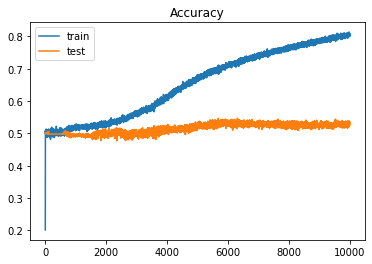

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest/assets


In [24]:
def train_lstm(X_train, y_train, X_test, y_test, lstm_units=50, dropout_prob=0.5, n_classes=3, epochs=6000, batch_size=32768):
    # We have now reshaped the data into the following format (#values, #time-steps, #1 dimensional output).
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], n_classes))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], n_classes))

    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True,
                input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_prob))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True))
    model.add(Dropout(dropout_prob))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True))
    model.add(Dropout(dropout_prob))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))
    # Adding the output layer
    # model.add(Dense(units=1))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Adam optimizer
    opt = Adam(learning_rate=0.0005, epsilon=1e-06, decay=1e-06)
    # # PiecewiseConstantDecay optimizer
    # boundaries = [200, 800, 2000, 4000]
    # values = [0.01, 0.001, 0.0005, 0.0001, 0.00001]
    # opt = keras.optimizers.schedules.PiecewiseConstantDecay(
    #     boundaries, values)

    checkpoint = ModelCheckpoint("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc", monitor='val_accuracy', verbose=2,
                                 save_best_only=True, mode='auto')

    # Compiling the RNN
    # model.compile(optimizer = opt, loss = 'mean_squared_error')
    # model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fitting the RNN to the Training set
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=batch_size,
                        callbacks=[checkpoint])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train)
    _, test_acc = model.evaluate(X_test, y_test)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    # plot loss during training
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

    return model

model = train_lstm(X_train_scaled, y_train_scaled_categorical,
                   X_test_scaled, y_test_scaled_categorical,
                   lstm_units=lstm_units, dropout_prob=dropout_prob, n_classes=3,
                   epochs=epochs, batch_size=batch_size)
model.save('/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest')

### Test model

In [25]:
def calc_confusion_matrix(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    cm = confusion_matrix(y_true_direction, y_pred_direction, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[-1, 0, 1])
    disp.plot()
    return cm

def calc_accuracy(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    return accuracy_score(y_true_direction, y_pred_direction)

In [26]:
# X_test = X_train
lstm_model = keras.models.load_model("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc")

In [27]:
#@title Define some params for make decision { run: "auto" }
min_price_change = 0 #@param {type:"number"}


In [28]:
y_pred = lstm_model.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1)))

In [29]:
y_test_scaled_categorical, y_pred

(array([[0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.]], dtype=float32),
 array([[4.0650848e-01, 4.9337299e-09, 5.9349149e-01],
        [4.1398216e-02, 2.5957608e-10, 9.5860177e-01],
        [5.7040441e-01, 7.8181088e-09, 4.2959556e-01],
        ...,
        [5.1660460e-01, 1.3485072e-09, 4.8339543e-01],
        [5.5950564e-01, 2.3166800e-09, 4.4049436e-01],
        [5.3246891e-01, 9.9460431e-09, 4.6753111e-01]], dtype=float32))

confusion_matrix: [[478   0 524]
 [  0   0   0]
 [379   0 615]]
acc: 0.5475951903807615
confusion_matrix: [[2867    0 1066]
 [   0    0    0]
 [ 700    0 3350]]
acc: 0.7787799073030189


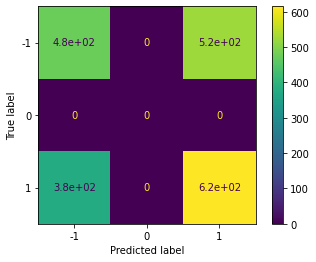

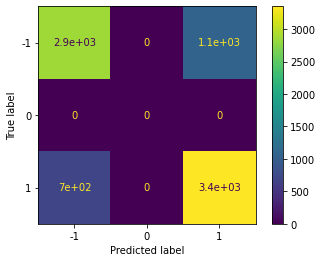

In [30]:
def show_val_res_label(y_true_label, y_pred_label):
    y_true_label = y_true_label - 1
    y_pred_label = y_pred_label - 1
    cm = confusion_matrix(y_true_label, y_pred_label, labels=[-1, 0, 1])
    print('confusion_matrix:', cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[-1, 0, 1])
    disp.plot()

    acc = accuracy_score(y_true_label, y_pred_label)
    print('acc:', acc)

def show_val_res_categorical(y_true, y_pred):
    y_true_label = np.argmax(y_true, axis=1)
    y_pred_label = np.argmax(y_pred, axis=1)
    show_val_res_label(y_true_label, y_pred_label)

show_val_res_categorical(y_test_scaled_categorical, y_pred)
show_val_res_categorical(y_train_scaled_categorical, lstm_model.predict(np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))))

## XGBoost model

### Build model

In [31]:
#@title Build model
seed = 100 #@param {type:"integer"}
n_estimators = 100 #@param {type:"integer"}
max_depth = 3 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
min_child_weight = 0 #@param {type:"number"}
subsample = 1 #@param {type:"number"}
colsample_bytree = 1 #@param {type:"number"}
colsample_bylevel = 1 #@param {type:"number"}
gamma = 0 #@param {type:"number"}
from xgboost import XGBClassifier

# xgbmodel = XGBClassifier(seed=seed,
#                         n_estimators=n_estimators,
#                         max_depth=max_depth,
#                         learning_rate=learning_rate,
#                         min_child_weight=min_child_weight,
#                         subsample=subsample,
#                         colsample_bytree=colsample_bytree,
#                         colsample_bylevel=colsample_bylevel,
#                         gamma=gamma)
xgbmodel = XGBClassifier()

### Train the model

In [32]:
xgbmodel.fit(X_train_scaled, y_train_scaled_label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Test model

In [33]:
y_pred = xgbmodel.predict(X_test_scaled)

confusion_matrix: [[454   0 548]
 [  0   0   0]
 [417   0 577]]
acc: 0.5165330661322646


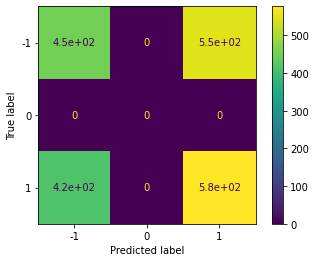

In [34]:
show_val_res_label(y_test_scaled_label, y_pred)